(sec:opencv)=
# OpenCVの基本

OpenCVとは元々Intel社が1999年から開発を開始した画像処理およびコンピュータビジョン用のライブラリでバージョン1.0が2006年に公開された当初はC言語で書かれていた。その後、開発が進められ、現在の最新バージョンである4.x系はPythonを含む非常に多くの言語でラッパーが公開されている。OpenCVで行える計算は画像の読み書きや、単純な画像フィルタの他、画像からの三次元復元や機械学習など幅広いが、ここでは基本的な機能に絞って解説する。

## 画像の読み書き

まずは講義の[GitHub](https://github.com/tatsy/sds-1284-ml/tree/master/Images)にアクセスして、3枚ある画像から好きなものを一つダウンロードしよう。その画像 (以下は`sunflower.jpg`とする)をIPythonを起動しているディレクトリと同じディレクトリに配置して、画像を読み込んでみよう。

なお、IPythonでどこのディレクトリを開いているか分からなくなった場合には、

In [1]:
import os

os.getcwd()

'/Users/tatsuya/Documents/Programs/Python/1284-sds-ml-advanced/contents/sec1'

とすることで、現在IPythonが実行されているディレクトリを調べることができる。ただ、このようなことが起こらないように、**講義用の作業用ディレクトリを作っておくのが一番おすすめ**である。

さて、画像の用意ができたら、以下のコードをタイプして、画像を読み込んでみる。

In [2]:
import cv2

img = cv2.imread("../../data/sunflower.jpg", cv2.IMREAD_COLOR)

もし画像の読み込みに失敗すると`img`が`None`となるので、以下のようなエラーチェックを入れておくと、些細な間違いを防ぐことができる。

In [3]:
if img is None:
    raise Exception("Failed to load image!")

画像が読み込めたら`shape`メソッドで大きさを確認してみましょう。正しく読み込めていれば、サイズは2048x1360となっているはずだ。ただし、OpenCVは画像の大きさを「高さ」×「幅」で表現しているため、幅が最初に来ること、そしてカラー画像として読み込んでいるので、赤・緑・青の色の強さを表わすチャネル数である3が末尾に追加されて以下のように出力される。

In [4]:
print(img.shape)

(1360, 2048, 3)


次に、ここで読みこんだ画像をMatplotlibを使って確認してみよう。画像の表示には`plt.imshow`を使う。

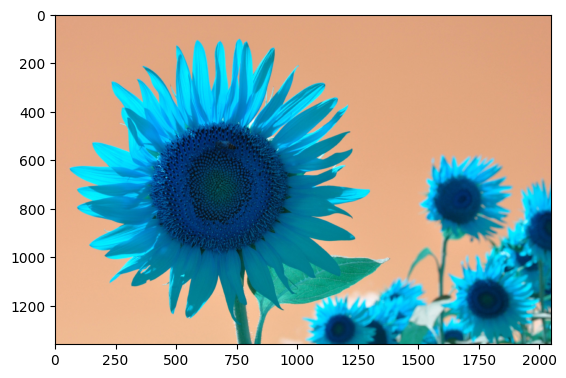

In [5]:
import matplotlib.pyplot as plt

plt.imshow(img)
plt.show()

ご覧の通り、色合いがおかしな画像になっていることが分かる。これは、OpenCVでカラー画像を読み込むと色を表わす3チャネルが赤・緑・青 (RGB)の順番ではなく青・緑・赤 (BGR)の逆順になっているためで、これを直すには以下のように色表現を変更する必要がある。

In [6]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

この処理を加えた後、同様に`plt.imshow`を用いて画像を表示してみると、以下のような正しい出力が得られる。なお、単に画像を表示したい時は軸が余計に感じられるので、その場合は`plt.axis("off")`あるいは`plt.xticks([])`、`plt.yticks([])`を呼び出すとよい。

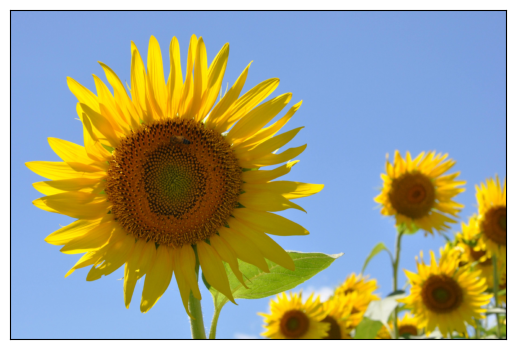

In [7]:
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.show()

```{admonition} 画像の色表現
:class: note

上記のプログラムではOpenCVを用いてカラー画像を読み込みましたが、各画素の色は赤・緑・青の三要素を用いて表わされていた。これは、光の三原色と呼ばれる色で、人間の目が捉える様々な波長の光のうち、特徴的な三つの成分を取りだして表現しているものと考えられる (厳密には各波長の感度には幅がある)。デジタル画像の表現形式は、この光の三原色を基本としたRGB表色に従っていることが一般的である (例えばJPEGやPNGなど)。

光の三原色は色を混ぜると白に近づくことで、例えばRGBの各値が一般的なデジタル画像における最大値である(255, 255, 255)を取ると、それは白色に対応する。このような重ね合わせることで明るくなっていく表色系のことを加法混色という。逆に、絵の具を混ぜた時のように、色を重ねるごとに黒に近づいていく表色系のことを減法混色という。

デジタル画像の保存にRGB形式が広く用いられる一方で、実際の応用に画像(や動画)を用いる際には、別の表色系が好まれることがある。例えば、テレビ映像を伝送する際には、帯域を削減する目的でYUVやYCbCrといった異なる表色が用いられる。また、プリンタに対して色情報を送るときには加法混色に従うRGB表色系ではなく、プリンタのインクが従う減法混色系の一種であるCMYK表色系 (C=シアン、M=マゼンタ、Y=イエロー、K=キープレート=黒)が用いられるのが一般的である。
```

## 画像に対する幾何学的操作

### 画像の拡大・縮小

画像の拡大・縮小には`cv2.resize`関数を使う。この関数は

In [8]:
img_small = cv2.resize(img, (1024, 680))

のように、拡大縮小後のサイズを指定する方法と

In [9]:
img_small = cv2.resize(img, None, fx=0.5, fy=0.5)

のように拡大・縮小の倍率を指定する2つの方法がある。

また、画像を拡大・縮小するときには拡大・縮小後の各画素の色を決定する方法としていくつかの方法があり、これを信号処理の用語ではリサンプリングと呼ぶ。

最も一般的な方式はバイリニア補間と呼ばれる方式で、これは周囲の4つの画素をx方向とy方向の2方向で線形補間 (リニア補間)する方法である。これ以外にも、単純に最も近い画素の値を用いるニアレスト補間や、より多くの周囲の画素の並びから色を決定するバイキュービック補間などが広く用いられている。

In [10]:
img_nearest = cv2.resize(img, (1024, 680), interpolation=cv2.INTER_NEAREST)  # ニアレスト補間
img_bilinear = cv2.resize(img, (1024, 680), interpolation=cv2.INTER_LINEAR)  # バイリニア補間
img_bicubic = cv2.resize(img, (1024, 680), interpolation=cv2.INTER_CUBIC)  # バイキュービック補間

なお、**極端に画像を小さくする**ときには、バイリニア補完等よりも、1画素に縮退する画素値の重み付き平均を用いる`INTER_AREA`オプションが非常に良く働く。なお`INTER_AREA`オプションは画像を拡大するときには`INTER_NEAREST`と変わらないので注意。

In [11]:
img_bilinear = cv2.resize(img, (128, 85), interpolation=cv2.INTER_LINEAR)  # ニアレスト補間
img_bicubic = cv2.resize(img, (128, 85), interpolation=cv2.INTER_CUBIC)  # バイリニア補間
img_area = cv2.resize(img, (128, 85), interpolation=cv2.INTER_AREA)  # バイキュービック補間

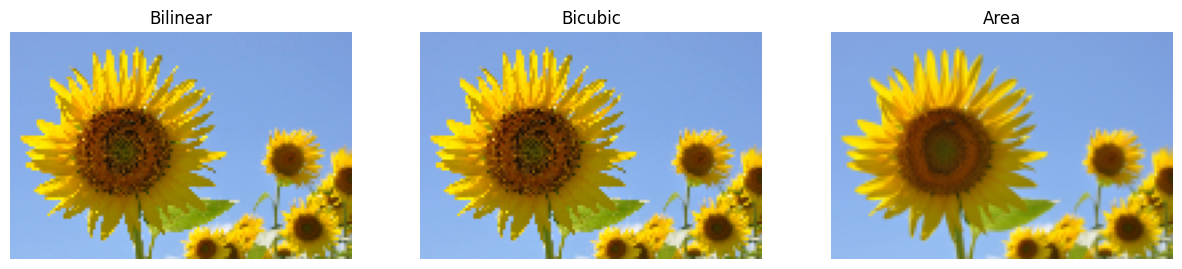

In [12]:
fig = plt.figure(figsize=(5 * 3, 5))
ax1 = fig.add_subplot(131)
ax1.imshow(img_bilinear)
ax1.axis("off")
ax1.set_title("Bilinear")

ax2 = fig.add_subplot(132)
ax2.imshow(img_bicubic)
ax2.axis("off")
ax2.set_title("Bicubic")

ax3 = fig.add_subplot(133)
ax3.imshow(img_area)
ax3.axis("off")
ax3.set_title("Area")

plt.show()

### 画像の回転

画像を回転される方法は90度刻みでの回転に使える`cv2.rotate`と、より細かな回転(+幾何的な変形)に対応できる`cv2.warpAffine`を使う方法の二通りがある。

まず`cv2.rotate`を使う場合だが、この関数は第一引数に回転させる画像を、第2引数に回転の量を表わすフラグとして以下のいずれかを取る。

* `cv2.ROTATE_90_CLOCKWISE` - 時計回りに90°回転
* `cv2.ROTATE_90_COUNTERCLOCKWISE` - 反時計回りに90°回転
* `cv2.ROTATE_180` - 180°回転 (回転方向に依らず結果は同じ)

一例として、反時計回りに90°回転させてみる。

In [13]:
img_rot = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)

すると、以下のような画像が得られる。

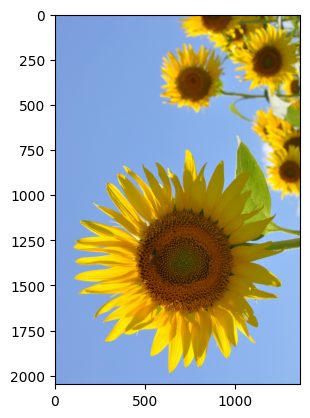

In [14]:
plt.imshow(img_rot)
plt.show()

続いて`cv2.warpAffine`を用いる方法だが、この関数は名前の通り、アフィン変換に基づいて画像を変形する関数だ。ここでは、アフィン変換について詳細に解説することは避けるが、アフィン変換は2x3の行列を使って、画素の座標を変換することで画像のリサンプリングを行う。

2x3の行列は一般には、
\begin{equation*}
\begin{pmatrix}
a & b & c \\
d & e & f
\end{pmatrix}
\end{equation*}
のように表わされるが、アフィン変換では左側の2x2の成分(a, b, d, eを成分に持つ箇所)が回転や拡大縮小などの成分、右側の2x1の成分(c, fを成分に持つ箇所)が平行移動量を表わす。

一例として、反時計回りに90°回転させたいのであれば、それに相当するアフィン変換の行列は「画像の中心を回転中心」として「反時計回りに90°」回転させる操作を表わすものである必要がある。このような行列は
1. 画像の中心を原点に移動する平行移動
1. 原点を中心として反時計回りに90°回転
1. 原点にある画像の中心を元の位置に戻すための平行移動
という3つの基本操作を組み合わせる必要がある。

ここでは、上記の三つの操作に対応する行列をそれぞれ$M_1$, $M_2$, $M_3$とすることにしよう。すると、そのそれぞれは以下のように表せる。

\begin{equation*}
M_1 = \begin{pmatrix}
  1 & 0 & - W / 2 \\
  0 & 1 & - H / 2
\end{pmatrix}, \quad
M_2 = \begin{pmatrix}
  \cos (-90^\circ) & -\sin (-90^\circ) & 0 \\
  \sin (-90^\circ) & \cos (-90^\circ) & 0
\end{pmatrix}, \quad
M_3 = \begin{pmatrix}
  1 & 0 & W / 2 \\
  0 & 1 & H / 2
\end{pmatrix}
\end{equation*}

のようになる。一般に上記のような回転行列の表現はx軸が右向き正、y軸が上向き正の時には反時計回りの回転を表わすのだが、**画像の座標系はy軸下向きが正に取られている**ため、時計回りが回転方向正になることに注意してほしい。

そこで、これらの行列と`cv2.warpAffine`を使って画像を回転してみる。なお、上記のアフィン変換(2x3行列)の合成変換を求めるために、各変換を3x3の行列として定義していることに注意すること。

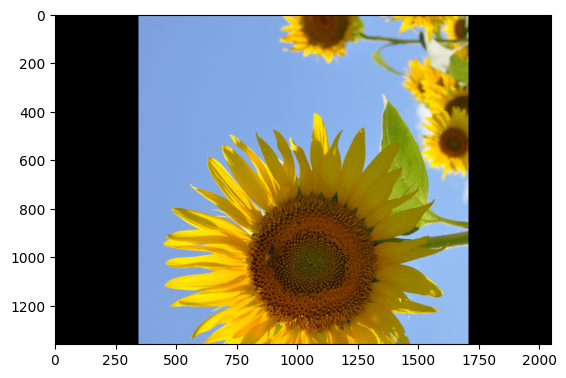

In [15]:
import numpy as np

H, W, _ = img.shape
M1 = np.array([[1.0, 0.0, -W / 2], [0.0, 1.0, -H / 2], [0.0, 0.0, 1.0]])
M2 = np.array(
    [
        [np.cos(-0.5 * np.pi), -np.sin(-0.5 * np.pi), 0.0],
        [np.sin(-0.5 * np.pi), np.cos(-0.5 * np.pi), 0.0],
        [0.0, 0.0, 1.0],
    ]
)
M3 = np.array([[1.0, 0.0, W / 2], [0.0, 1.0, H / 2], [0.0, 0.0, 1.0]])

M = M3 @ M2 @ M1
img_rot = cv2.warpAffine(img, M[:2, :], (W, H))

plt.imshow(img_rot)
plt.show()

`cv2.warpAffine`は画像領域自体は変形しないため、`cv2.rotate`とは違い両端に黒い領域が現れてしまっているが、回転のされ方としては正しい回転となっていることが分かる。

なお、ここまでアフィン変換の仕組みを説明するために回りくどい方法を用いたが、OpenCVには画像を回転させる行列を得るための関数として`cv2.getRotationMatrix2D`が用意されており、上記のプログラムと同じ出力なら以下のように得られる。

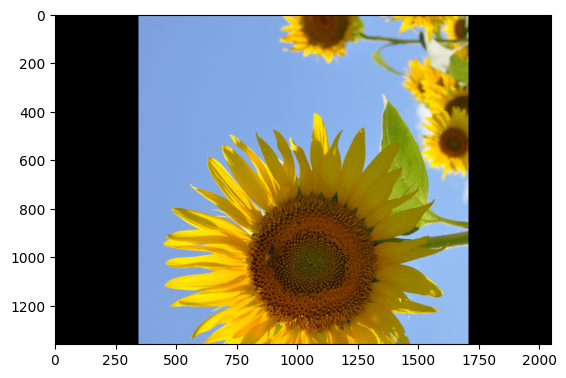

In [16]:
H, W, _ = img.shape
M = cv2.getRotationMatrix2D(center=(W / 2, H / 2), angle=90, scale=1.0)
img_rot = cv2.warpAffine(img, M, (W, H))
plt.imshow(img_rot)
plt.show()

### 画像の反転

画像の反転を行う方法にも `cv2.flip` を用いる方法と `cv2.warpAffine` を用いる方法の二種類がある。それぞれ見ていこう。

`cv2.flip`を用いる場合は、第1引数に画像を、第2引数に反転の種類を表わす数字を入力する。この数字(`flipcode`)は0、正、負の三種類で挙動が変わるようになっており、
- 0: 上下方向(X軸を中心に)に反転
- 正: 左右方向(Y軸を中心に)に反転
- 負: 縦横両方の反転
に対応している。

In [17]:
img_flip_x = cv2.flip(img, 0)  # 上下反転
img_flip_y = cv2.flip(img, 1)  # 左右反転
img_flip_both = cv2.flip(img, -1)  # 上下左右反転

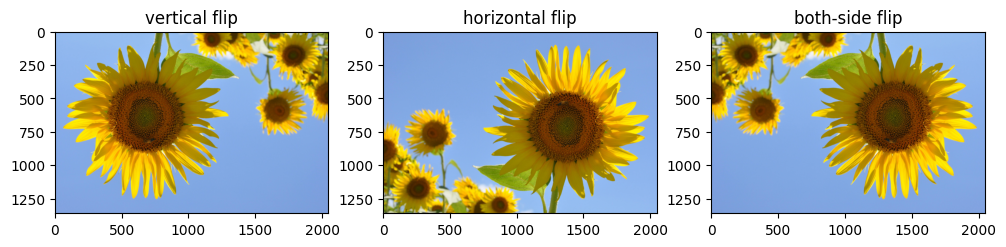

In [18]:
fig = plt.figure(figsize=(12, 4))

# 上下反転
ax = fig.add_subplot(131)
ax.imshow(img_flip_x)
ax.set_title("vertical flip")

# 左右反転
ax = fig.add_subplot(132)
ax.imshow(img_flip_y)
ax.set_title("horizontal flip")

# 上下左右反転
ax = fig.add_subplot(133)
ax.imshow(img_flip_both)
ax.set_title("both-side flip")

plt.show()

また、余談にはなるが、NumPyにも配列の上下左右を入れ替えるメソッドが用意されており、上下反転なら`np.flipud`、左右反転なら `np.fliplr`、左右両方に回転させたい場合には `np.flip` の第2引数に縦を縦軸を表わす0, 横軸を表わす1という軸のインデックスを配列として指定すれば良い。

In [19]:
img_flip_x = np.flipud(img)  # 上下反転
img_flip_y = np.fliplr(img)  # 左右反転
img_flip_both = np.flip(img, axis=[0, 1])  # 上下左右反転

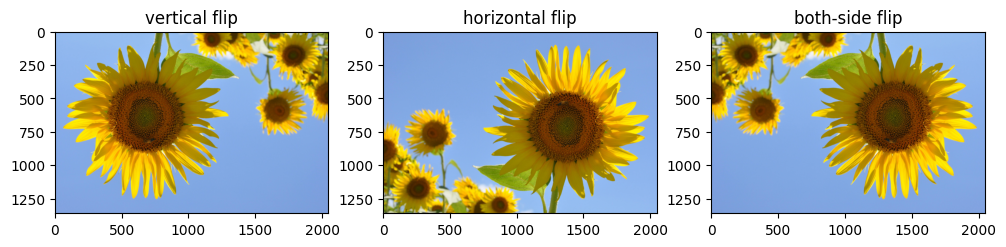

In [20]:
fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(131)
ax.imshow(img_flip_x)
ax.set_title("vertical flip")

ax = fig.add_subplot(132)
ax.imshow(img_flip_y)
ax.set_title("horizontal flip")

ax = fig.add_subplot(133)
ax.imshow(img_flip_both)
ax.set_title("both-side flip")

plt.show()

また、最後に `cv2.warpAffine` を用いる方法についてだが、こちらは、X軸対称、Y軸対称、X-Y両軸対称の反転を意味する行列 $M_1$、$M_2$、$M_3$ がそれぞれ

$$
M_1= \begin{pmatrix}
1 & 0 & 0 \\
0 & -1 & H 
\end{pmatrix}, \quad
M_2= \begin{pmatrix}
-1 & 0 & W \\
0 & 1 & 0 
\end{pmatrix}, \quad
M_3= \begin{pmatrix}
-1 & 0 & W \\
0 & -1 & H 
\end{pmatrix}
$$

のように表せることから、以下のようなコードにより、`cv2.flip`等と同様の効果を得ることができる。なお、上記の行列で単に対角成分を`-1`にするだけだと、画像の表示領域から画素がはみ出してしまうため、反転した後に反転した方向の画素数分だけ正の方向に平行移動する成分が第3列に入っていることに注意してほしい。

In [21]:
H, W = img.shape[:2]

# 上下反転
M_1 = np.array([[1, 0, 0], [0, -1, H]], dtype="float32")
img_flip_x = cv2.warpAffine(img, M_1, (W, H))

# 左右反転
M_2 = np.array([[-1, 0, W], [0, 1, 0]], dtype="float32")
img_flip_y = cv2.warpAffine(img, M_2, (W, H))

# 上下左右反転
M_3 = np.array([[-1, 0, W], [0, -1, H]], dtype="float32")
img_flip_both = cv2.warpAffine(img, M_3, (W, H))

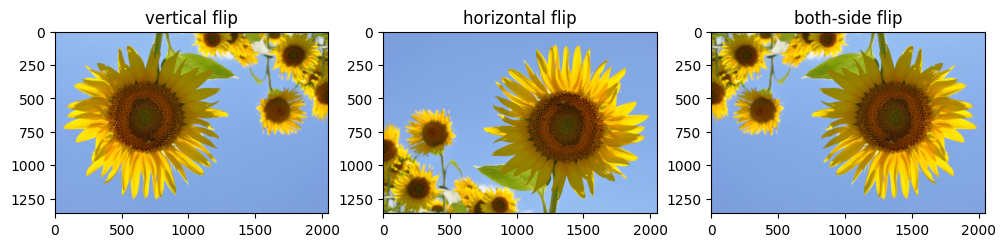

In [22]:
fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(131)
ax.imshow(img_flip_x)
ax.set_title("vertical flip")

ax = fig.add_subplot(132)
ax.imshow(img_flip_y)
ax.set_title("horizontal flip")

ax = fig.add_subplot(133)
ax.imshow(img_flip_both)
ax.set_title("both-side flip")

plt.show()

## 画像フィルタ

画像のフィルタ処理は

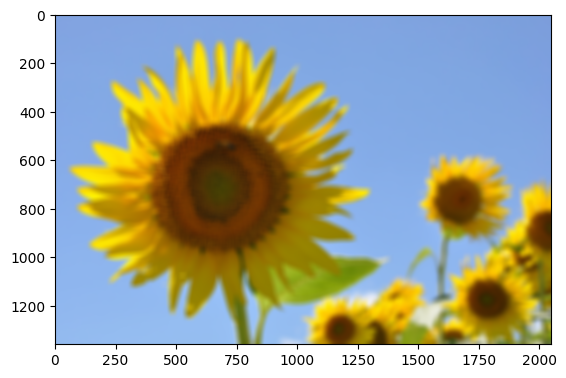

In [23]:
img_gauss = cv2.GaussianBlur(img, (31, 31), 15.0)
plt.imshow(img_gauss)
plt.show()

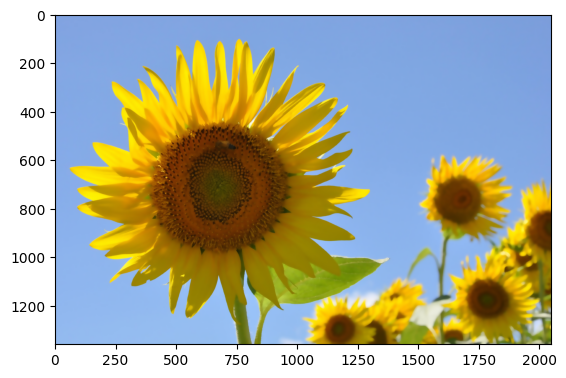

In [24]:
img_bilat = cv2.bilateralFilter(img, 15, sigmaColor=50.0, sigmaSpace=30.0)
plt.imshow(img_bilat)
plt.show()

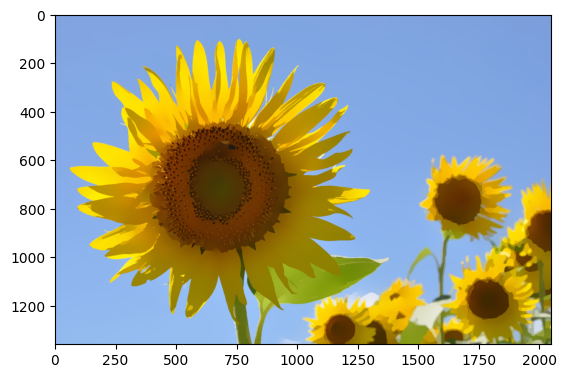

In [25]:
img_bilat_rep = img.copy()
for i in range(20):
    img_bilat_rep = cv2.bilateralFilter(img_bilat_rep, 21, sigmaColor=15.0, sigmaSpace=30.0)
plt.imshow(img_bilat_rep)
plt.show()

(edge-detection)=
### エッジ抽出フィルタ

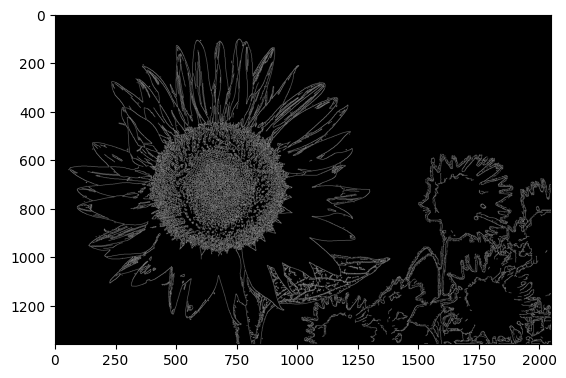

In [26]:
img_canny = cv2.Canny(img, 50, 100)
plt.imshow(img_canny, cmap="gray")
plt.show()

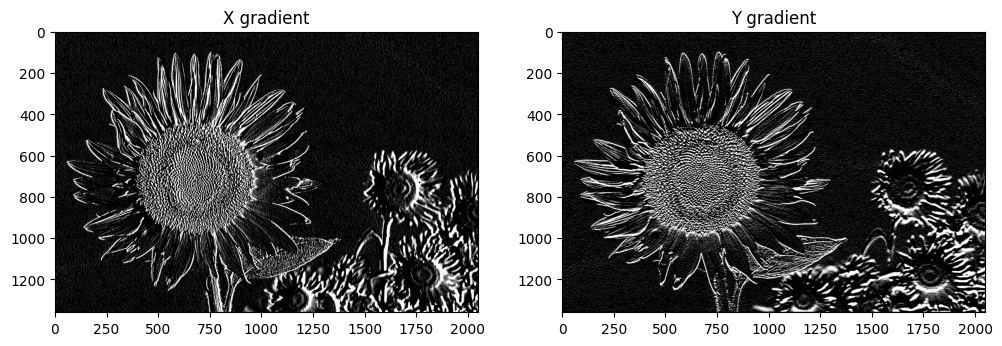

In [27]:
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

img_sobel_x = cv2.Sobel(img_gray, cv2.CV_8U, 1, 0, ksize=5)
img_sobel_y = cv2.Sobel(img_gray, cv2.CV_8U, 0, 1, ksize=5)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121)
ax.imshow(img_sobel_x, cmap="gray")
ax.set_title("X gradient")
ax = fig.add_subplot(122)
ax.imshow(img_sobel_y, cmap="gray")
ax.set_title("Y gradient")
plt.show()

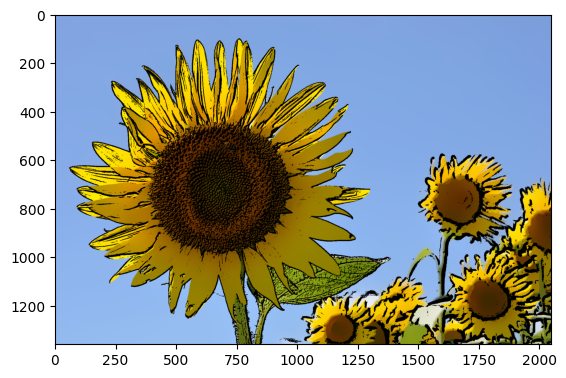

In [28]:
# エッジ強度のノルムを取る
img_sobel_mag = np.sqrt(img_sobel_x.astype("float32") ** 2 + img_sobel_y.astype("float32") ** 2)
img_sobel_mag = np.clip(img_sobel_mag, 0, 255).astype("uint8")

# エッジを二値化する
_, edge_mask = cv2.threshold(img_sobel_mag, 216, 255, cv2.THRESH_BINARY_INV)

# バイラテラルフィルタのぼかし画像にエッジを適用
img_illust = img_bilat_rep * (edge_mask[:, :, None] // 255)

# 表示
plt.imshow(img_illust)
plt.show()